# IBM MACHINE LEARNING - PROJECT C 

## Fault Classification in Photovoltaic Plants

### 1 - General Information About the Dataset

**This dataset is published by Lazzaretti, A. E. et al.  (2020) in a paper named "A Monitoring System for Online Fault Detection and Classification in Photovoltaic Plants" in Sensors journal [1]. The authors collected the data of grid-tie PV panels in a solar plant for 16 consecutive days. The used PV plant has 2 string with 8x C6SU-330P PV Modules each. Both of the strings are attached to a 5kW grid-tie power inverter (NHS Solar 5K-GDM1). The labels in this dataset are used to demonstrate the operation status of the PV, i.e., normal or faulty, and they are as follows,**<br>



| Label | Meaning | Description |
| --- | --- | --- |
| 0 | Normal Operation | No faults |
| 1 | Short-Circuit | Short Circuit between 2 modules of a String |
| 2 | Degradation | There is a resistance between 2 modules of a String |
| 3 | Open Circuit | One String disconnected from the power inverter |
| 4 | Shadowing | Shadow in one or more modules |


**Furthermore, the independent features descriptions are as follows,** <br>

| Label | Meaning | Description |
| --- | --- | --- |
| Vdc1 | String 1 voltage | Direct volt |
| Vdc2 | String 2 voltage | Direct volt|
| Idc1 | String 1 current | Direct current |
| Idc2 | String 2 current | Direct current |
| irradiance | Sun Irradiance | Watt/square m |
|pvtemp|PV Temperature| Measured in celsius |

**Data link on GitHub https://github.com/clayton-h-costa/pv_fault_dataset**<br>
**The original dataset dimensions are [1,373,798 instances and 7 features], due to limit computational resources, I reduced dataset size by ~58% while also maintaining the ratio approximation. Moreover, the form of data is .mat, I converted it to a csv file in MATLAB using the following code.**

#### MATLAB CODE
load('dataset_elec.mat')

load('dataset_amb.mat')

% most columns need to be transposed.

Idc1 = idc1';

Idc2 = idc2';

irradiance = irr';

pvtemp = pvt';

Vdc1 = vdc1';

Vdc2 = vdc2';

myT = table(Idc1,Idc2,Vdc1,Vdc2,irradiance,pvtemp,f_nv); % Creating the table

head(myT) 

writetable(myT,'PVdata.csv') % export to a csv file.

### 2 - Analysis Objectives
**A - to find the impact of voltage, current, irradiance, and temperature on PV panels.**<br>
**B - To reduce the imbalance between classes effect.**<br>
**C - To use GridSearchCV to find the best parameters.**<br>
**D - To benchmark Logisitc Regression vs Decision Trees vs Random Forest.**

In [1]:
# Dataframe and plotting libraries
import numpy as np # For linear algebra
import pandas as pd # For data frame manipulation
import seaborn as sns # For visualization I
import matplotlib.pyplot as plt # For visualization II


# Machine Learing libraries
from sklearn.linear_model import LogisticRegression # Model 1
from sklearn.tree import DecisionTreeClassifier # Model 2
from sklearn.ensemble import RandomForestClassifier # Model 3


from sklearn.model_selection import StratifiedShuffleSplit # To stratify split
from sklearn.model_selection import StratifiedKFold # To stratify kfolds
from sklearn.model_selection import GridSearchCV # To find best parameters 
from sklearn.metrics import accuracy_score, precision_recall_fscore_support # To evaluate models
from sklearn.metrics import classification_report # To evaluate models
from sklearn.metrics import confusion_matrix # To plot models outcome


from sklearn.preprocessing import MinMaxScaler # To scale data
from imblearn.under_sampling import RandomUnderSampler # To undersample data
from imblearn.over_sampling import RandomOverSampler, SMOTE # To oversample and resample data


# Utility library
import pickle # Save the ML object model.
import os # To access directory
import warnings  # To mute warnings
warnings.filterwarnings("ignore") # Mute warning
os.chdir('/Users/salahkaf/Desktop/data') # Changing working directory


%matplotlib inline 

In [2]:
# Defining auxiliary function 1
rs = 123 # Setting random state to '123' in all models and sampling.

# Defining auxiliary function 2
# evaluation metrics stored in a dictionary
def evaluate_metrics(yt, yp):
    results_pos = {}
    results_pos['accuracy'] = accuracy_score(yt, yp)
    
    precision, recall, f_beta, _ = precision_recall_fscore_support(yt, yp)
    W_precision, W_recall, W_fbeta, _ = precision_recall_fscore_support(yt, yp, average = 'weighted')
    
    results_pos['precision'] = precision
    results_pos['Weighted precision'] = W_precision
    results_pos['recall'] = recall
    results_pos['Weighted recall'] = W_recall
    results_pos['f1score'] = f_beta
    results_pos['Weighted f1score'] = W_fbeta
    return results_pos

In [3]:
df = pd.read_csv('PVdata.csv', sep  = ',')# Reading the df

#### Basic understanding about the dataset

In [4]:
print('The dataset first three rows are')
display(df.head(3))
print('')
print('The dataset last three rows are')
display(df.tail(3))

The dataset first three rows are


,Idc1,Idc2,Vdc1,Vdc2,irradiance,pvtemp,f_nv
0,0.0646,0.0067,0.7110,0.5583,1.5118,2.3883,0
1,0.0628,0.0067,0.6991,0.5465,1.5534,2.3920,0
2,0.0606,0.0076,0.7035,0.5553,1.4355,2.3920,0



The dataset last three rows are


,Idc1,Idc2,Vdc1,Vdc2,irradiance,pvtemp,f_nv
583061,0.1067,0.0359,0.5447,0.6187,0.9478,10.4333,0
583062,0.1118,0.0360,0.5621,0.6327,0.9769,10.4333,0
583063,0.1121,0.0370,0.5352,0.6221,1.1632,10.4313,0


In [5]:
print(f'The data frame encompasses {df.shape[0]} instances and {df.shape[1]} features\n')
print('The features data types are as follows,')
print(df.dtypes.value_counts())

The data frame encompasses 583064 instances and 7 features

The features data types are as follows,
float64    6
int64      1
dtype: int64


In [6]:
print('Checking for missing values per column:')
print(df.isna().sum())

Checking for missing values per column:
Idc1          0
Idc2          0
Vdc1          0
Vdc2          0
irradiance    0
pvtemp        0
f_nv          0
dtype: int64


In [7]:
print('The target feature is class, i.e., fault type, distributed in the dataset as follows,')
print(df['f_nv'].value_counts())
print('')
print('the ratios of classes are as follows')
print(df['f_nv'].value_counts(normalize = True))

The target feature is class, i.e., fault type, distributed in the dataset as follows,
0    470714
4     89956
2     10371
3      6024
1      5999
Name: f_nv, dtype: int64

the ratios of classes are as follows
0    0.807311
4    0.154282
2    0.017787
3    0.010332
1    0.010289
Name: f_nv, dtype: float64


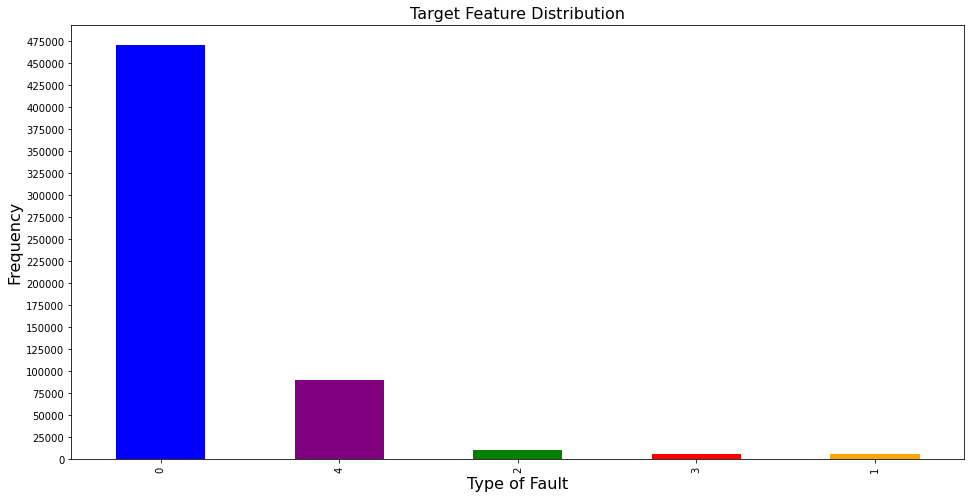

In [8]:
# Plotting the ratio between classes
from matplotlib.pyplot import figure

fig, ax = plt.subplots(figsize=(16, 8))
df['f_nv'].value_counts().plot.bar(color= ['blue','purple','green','red','orange'])
ax.set_ylabel('Frequency',fontsize=16)
ax.set_xlabel('Type of Fault',fontsize=16)
ax.set_title('Target Feature Distribution',fontsize=16)
ax.locator_params('y', nbins=20)
plt.show()

#### We observe that classes are extremely skewed, because 80% of them are labeled as '0', i.e., normal operation. To solve this matter, we will fit a logistic regression model and make predictions using the original dataset, and compare the results with three rebalanced datasets (downsampled dataset, rewighted dataset, and resampled dataset). Then, the rebalancing technique that achieves the highest average scores will be used to fit and evaluate other classification algorithms.

####  Moreover, rebalancing techniques will be applied only after doing validation-split to ensure that we mimic real world scenarios.

In [9]:
# Identifying the feature columns
feature_cols = df.drop('f_nv',axis = 1).columns.tolist()
feature_cols

['Idc1', 'Idc2', 'Vdc1', 'Vdc2', 'irradiance', 'pvtemp']

In [10]:
# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1, 
                                          test_size=0.25, # 25% to validate our models
                                          random_state=rs)

# We use 'next' to get the arrays from the generator object.
train_idx, test_idx = next(strat_shuf_split.split(df[feature_cols], df['f_nv']))
# next(strat_shuf_split.split(dataframe[feature_cols], dataframe['class']))

In [11]:
# Create the train and test sets
X_train = df.loc[train_idx, feature_cols] # loc[index,column]
y_train = df.loc[train_idx, 'f_nv']

X_test  = df.loc[test_idx, feature_cols]
y_test  = df.loc[test_idx, 'f_nv']

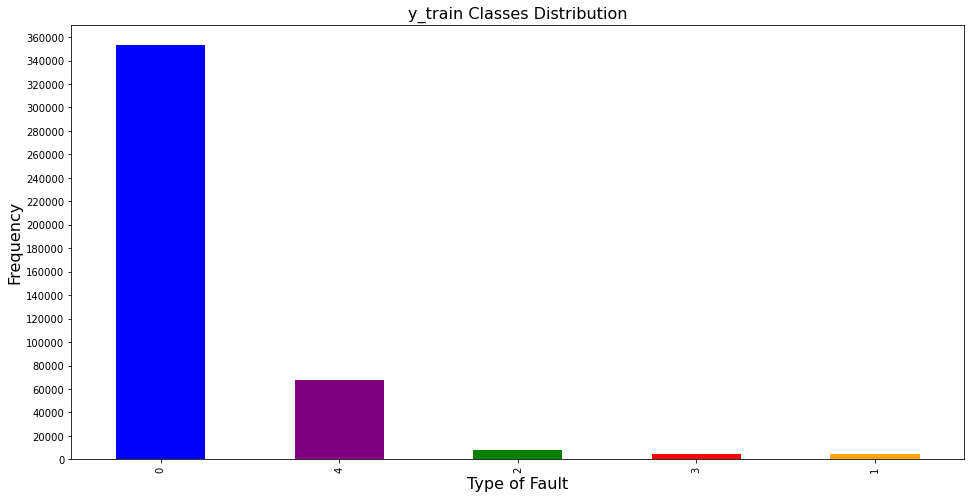

In [12]:
# Plotting y_train distribution
fig, ax = plt.subplots(figsize=(16, 8))
y_train.value_counts().plot.bar(color= ['blue','purple','green','red','orange'])
ax.set_xlabel('Type of Fault',fontsize=16)
ax.set_ylabel('Frequency',fontsize=16)
ax.set_title('y_train Classes Distribution',fontsize=16)
ax.locator_params('y', nbins=20)
plt.show()

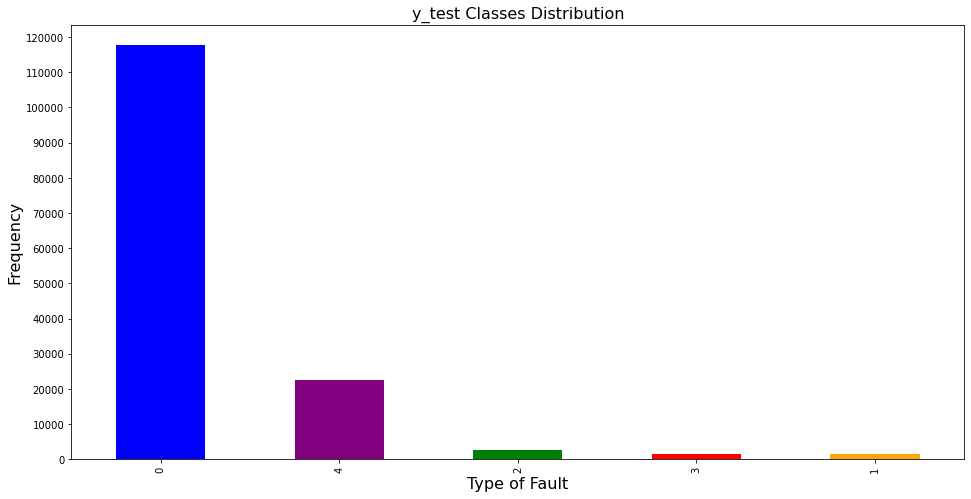

In [13]:
# Plotting y_test distribution
fig, ax = plt.subplots(figsize=(16, 8))
y_test.value_counts().plot.bar(color= ['blue','purple','green','red','orange'])
ax.set_xlabel('Type of Fault',fontsize=16)
ax.set_ylabel('Frequency',fontsize=16)
ax.set_title('y_test Classes Distribution',fontsize=16)
ax.locator_params('y', nbins=20)
plt.show()

### A - First Approach (Reweighting classes)

In [14]:
y_train.value_counts()

0    353036
4     67467
2      7778
3      4518
1      4499
Name: f_nv, dtype: int64

In [15]:
# Initially, let's scale data using min-max scaler. 
scaler = MinMaxScaler()
X_train_s = scaler.fit_transform(X_train) # Fit and transform. 
X_test_s = scaler.transform(X_test) # transform only.

In [16]:
class_weight = {}
# Weighting is approximated based on number of classes.
class_weight[0] = 0.05
class_weight[1] = 0.30
class_weight[2] = 0.20
class_weight[3] = 0.30
class_weight[4] = 0.15

In [17]:
# Define a logistic regression with weight
model = LogisticRegression(solver='saga', random_state=rs, class_weight=class_weight)
model.fit(X_train_s, y_train)
preds =  model.predict(X_test_s)

In [18]:
# Results
reweighted = evaluate_metrics(y_test,preds)
reweighted

{'accuracy': 0.9039282137123883,
 'precision': array([0.9611271 , 0.98031496, 0.49903148, 0.99209486, 0.71112904]),
 'Weighted precision': 0.9148543006241275,
 'recall': array([0.91942419, 0.996     , 0.79483224, 1.        , 0.82284673]),
 'Weighted recall': 0.9039282137123883,
 'f1score': array([0.93981325, 0.98809524, 0.61311914, 0.99603175, 0.76291975]),
 'Weighted f1score': 0.9077880307113514}

In [19]:
# Storing evaluation metrics (average values)
reweighted_results = list()
keys = ['accuracy','Weighted precision','Weighted recall','Weighted f1score']
for key in keys:
       reweighted_results.append(reweighted.get(key))
reweighted_results       

[0.9039282137123883,
 0.9148543006241275,
 0.9039282137123883,
 0.9077880307113514]

In [20]:
# storing evaluation metrics (per class)
reweighted_rpf = []
elements = ['precision','recall','f1score']
for element in elements:
       reweighted_rpf.append(reweighted.get(element))
reweighted_rpf       

[array([0.9611271 , 0.98031496, 0.49903148, 0.99209486, 0.71112904]),
 array([0.91942419, 0.996     , 0.79483224, 1.        , 0.82284673]),
 array([0.93981325, 0.98809524, 0.61311914, 0.99603175, 0.76291975])]

### B - Second Approach [Undersampling]

In [21]:
under_sampler = RandomUnderSampler(random_state=rs) #initiating undersampling object
X_under, y_under = under_sampler.fit_resample(X_train_s, y_train)

In [22]:
print('y_train after undersampling')
y_under.value_counts() 

y_train after undersampling


4    4499
3    4499
2    4499
1    4499
0    4499
Name: f_nv, dtype: int64

In [23]:
model = LogisticRegression(solver='saga', random_state=rs)
model.fit(X_under, y_under)
preds = model.predict(X_test_s)

In [24]:
undersampling = evaluate_metrics(y_test,preds)
undersampling

{'accuracy': 0.7925304940795521,
 'precision': array([0.98144409, 0.98548813, 0.17477876, 0.99209486, 0.55353008]),
 'Weighted precision': 0.9012269253809336,
 'recall': array([0.76003161, 0.996     , 0.97493251, 1.        , 0.91409133]),
 'Weighted recall': 0.7925304940795521,
 'f1score': array([0.85666258, 0.99071618, 0.29641789, 0.99603175, 0.68951985]),
 'Weighted f1score': 0.8237288574398645}

In [25]:
# Storing evaluation metrics (average values)
undersampling_results = list()
for key in keys:
       undersampling_results.append(undersampling.get(key))
undersampling_results

[0.7925304940795521,
 0.9012269253809336,
 0.7925304940795521,
 0.8237288574398645]

In [26]:
# storing evaluation metrics (per class)
undersampling_rpf = []
for element in elements:
       undersampling_rpf.append(undersampling.get(element))
undersampling_rpf    

[array([0.98144409, 0.98548813, 0.17477876, 0.99209486, 0.55353008]),
 array([0.76003161, 0.996     , 0.97493251, 1.        , 0.91409133]),
 array([0.85666258, 0.99071618, 0.29641789, 0.99603175, 0.68951985])]

### C -  Third Apporach [Resampling]

In [27]:
smote_sampler = SMOTE(random_state = rs) #Initiating SMOTE sampler
X_smo, y_smo = smote_sampler.fit_resample(X_train_s, y_train)

In [28]:
y_smo.value_counts()

4    353036
3    353036
2    353036
1    353036
0    353036
Name: f_nv, dtype: int64

In [29]:
model = LogisticRegression(solver='saga', random_state=rs)

In [30]:
model.fit(X_smo, y_smo)
preds = model.predict(X_test_s)

In [31]:
resampling = evaluate_metrics(y_test, preds)
resampling

{'accuracy': 0.8886434422293265,
 'precision': array([0.9832507 , 0.95028681, 0.46295961, 0.98560209, 0.64429823]),
 'Weighted precision': 0.921386329463096,
 'recall': array([0.87798059, 0.994     , 0.98573081, 1.        , 0.91876028]),
 'Weighted recall': 0.8886434422293265,
 'f1score': array([0.92763864, 0.971652  , 0.63002218, 0.99274885, 0.75743246]),
 'Weighted f1score': 0.89721034685069}

In [32]:
# Storing evaluation metrics (average values)
resampling_results = list()
for key in keys:
       resampling_results.append(resampling.get(key))
resampling_results

[0.8886434422293265, 0.921386329463096, 0.8886434422293265, 0.89721034685069]

In [33]:
# storing evaluation metrics (per class)
resampling_rpf = []
for element in elements:
       resampling_rpf.append(resampling.get(element))
resampling_rpf    

[array([0.9832507 , 0.95028681, 0.46295961, 0.98560209, 0.64429823]),
 array([0.87798059, 0.994     , 0.98573081, 1.        , 0.91876028]),
 array([0.92763864, 0.971652  , 0.63002218, 0.99274885, 0.75743246])]

In [34]:
final_results= {
    'Metric': ['Accuracy',' Weighted Precision','Weighted Recall','Weighted F1score'],
    'Reweighted' :reweighted_results,
    'Undersampled':undersampling_results,
    'Resampled':resampling_results}
final_results = pd.DataFrame(final_results).set_index('Metric')
display(final_results)

,Rewieghted,Undersampled,Resampled
Metric,,,
Accuracy,0.903928,0.792530,0.888643
Weighted Precision,0.914854,0.901227,0.921386
Weighted Recall,0.903928,0.792530,0.888643
Weighted F1score,0.907788,0.823729,0.897210


In [36]:
final_results_per_class = {
    'classes': [0,1,2,3,4],
    'Reweighted Precision' :reweighted_rpf[0],
    'Reweighted Recall' :reweighted_rpf[1],
    'Reweighted F1score' :reweighted_rpf[2],
    'Undersampled Precision':undersampling_rpf[0],
    'Undersampled Recall':undersampling_rpf[1],
    'Undersampled F1score':undersampling_rpf[2],
    'Resampled Precision':resampling_rpf[0],
    'Resampled Recall':resampling_rpf[1],
    'Resampled F1score':resampling_rpf[2]}
final_results_per_class = pd.DataFrame(final_results_per_class).set_index('classes')
final_results_per_class.T

classes,0,1,2,3,4
Reweighted Precision,0.961127,0.980315,0.499031,0.992095,0.711129
Reweighted Recall,0.919424,0.996000,0.794832,1.000000,0.822847
Reweighted F1score,0.939813,0.988095,0.613119,0.996032,0.762920
Undersampled Precision,0.981444,0.985488,0.174779,0.992095,0.553530
Undersampled Recall,0.760032,0.996000,0.974933,1.000000,0.914091
Undersampled F1score,0.856663,0.990716,0.296418,0.996032,0.689520
Resampled Precision,0.983251,0.950287,0.462960,0.985602,0.644298
Resampled Recall,0.877981,0.994000,0.985731,1.000000,0.918760
Resampled F1score,0.927639,0.971652,0.630022,0.992749,0.757432


#### Based on the above findings, reweighting is the best technique in terms of overall performance. Ergo, the classes will be reweighted accordingly in all the machine learning models.

### Machine Learning Models  

### Steps:
**1 - Initiating 4 stratified folds.**<br>
**2 - Run GridSearch on LR, DT, and RF.**<br>
**3 - Benchmark the models.**<br>
**4 - Select the most appropriate model.**

In [37]:
kf = StratifiedKFold(shuffle=True, random_state=rs , n_splits= 4 ) # 4 splits only to reduce time. 

`A - Logistic Regression`

In [38]:
# Identifying the param_grid to loop through it using GridSearchCV
param_grid = {'C':[0.1,1,10],
              'penalty':['l1', 'l2']}
model = LogisticRegression(random_state = rs, class_weight=class_weight, solver = 'saga')

In [39]:
search_lr = GridSearchCV(estimator=model,
                      param_grid=param_grid,
                      scoring='accuracy',
                      cv=kf,
                      n_jobs= -1) 
search_lr.fit(X_train_s, y_train)

/Users/salahkaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/salahkaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/salahkaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/salahkaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/salahkaf/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/salahkaf/opt/anaconda3/lib/p

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=123, shuffle=True),
             estimator=LogisticRegression(class_weight={0: 0.05, 1: 0.3, 2: 0.2,
                                                        3: 0.3, 4: 0.15},
                                          random_state=123, solver='saga'),
             n_jobs=-1, param_grid={'C': [0.1, 1, 10], 'penalty': ['l1', 'l2']},
             scoring='accuracy')

In [40]:
search_lr.best_score_

0.9286962244276853

In [41]:
search_lr.best_params_

{'C': 10, 'penalty': 'l1'}

In [42]:
lr_model = LogisticRegression(random_state = rs, C = 10, penalty = 'l1',class_weight=class_weight, solver = 'saga')

In [43]:
lr_model.fit(X_train_s, y_train)

LogisticRegression(C=10,
                   class_weight={0: 0.05, 1: 0.3, 2: 0.2, 3: 0.3, 4: 0.15},
                   penalty='l1', random_state=123, solver='saga')

In [44]:
preds = lr_model.predict(X_test_s)

In [45]:
logistic = evaluate_metrics(y_test, preds)
logistic # results dict

{'accuracy': 0.9282205726987088,
 'precision': array([0.96860681, 0.9726206 , 0.97713835, 0.99013807, 0.73623755]),
 'Weighted precision': 0.9331720515757812,
 'recall': array([0.94309896, 0.99466667, 0.95603548, 1.        , 0.83792076]),
 'Weighted recall': 0.9282205726987088,
 'f1score': array([0.95568271, 0.98352011, 0.96647173, 0.9950446 , 0.78379503]),
 'Weighted f1score': 0.9300486754286351}

              precision    recall  f1-score   support

           0       0.97      0.94      0.96    117678
           1       0.97      0.99      0.98      1500
           2       0.98      0.96      0.97      2593
           3       0.99      1.00      1.00      1506
           4       0.74      0.84      0.78     22489

    accuracy                           0.93    145766
   macro avg       0.93      0.95      0.94    145766
weighted avg       0.93      0.93      0.93    145766



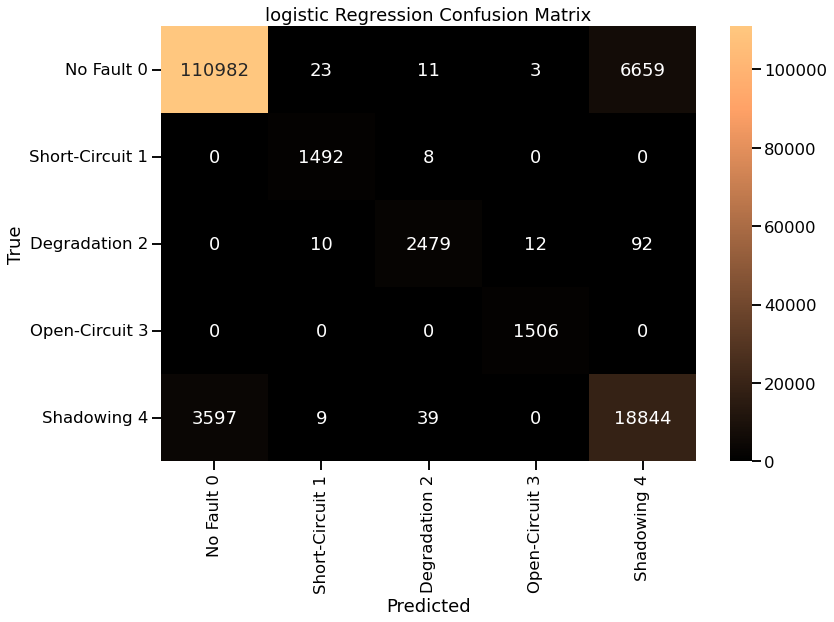

In [46]:
# Results in more understandable manner
print(classification_report(y_test, preds))

sns.set_context('talk')
cm = confusion_matrix(y_test, preds)
plt.figure(figsize = (12,8)) 
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='copper',
                xticklabels=['No Fault 0', 'Short-Circuit 1', 'Degradation 2','Open-Circuit 3','Shadowing 4'], 
                 yticklabels=['No Fault 0', 'Short-Circuit 1', 'Degradation 2','Open-Circuit 3','Shadowing 4'])
ax.set(title="logistic Regression Confusion Matrix");
ax.set_xlabel('Predicted');
ax.set_ylabel('True');

In [47]:
#Storing evaluation metrics (average values)
lr_results = list()
for key in keys:
       lr_results.append(logistic.get(key))
lr_results 

[0.9282205726987088,
 0.9331720515757812,
 0.9282205726987088,
 0.9300486754286351]

In [48]:
# storing evaluation metrics (per class)
lr_rpf = []
for element in elements:
       lr_rpf.append(logistic.get(element))
lr_rpf   

[array([0.96860681, 0.9726206 , 0.97713835, 0.99013807, 0.73623755]),
 array([0.94309896, 0.99466667, 0.95603548, 1.        , 0.83792076]),
 array([0.95568271, 0.98352011, 0.96647173, 0.9950446 , 0.78379503])]

In [49]:
# this will help us to resote the object even if the kernal is shutdown
pickle.dump(search_lr, open('search_lr.p','wb')) # write it as bytes
pickle.dump(lr_model, open('lr_model.p','wb')) # write it as bytes

`B - Decision Trees`

In [50]:
# Identifying the param_grid to loop through it using GridSearchCV

param_grid = {'criterion':['gini','entropy'],
              'max_depth':[1,3,5,7],
              'max_features' :[2,4,6]}
model = DecisionTreeClassifier(random_state = rs, class_weight = class_weight)

In [51]:
search_dt = GridSearchCV(estimator=model,
                      param_grid=param_grid,
                      scoring='accuracy',
                      cv=kf,
                      n_jobs = -1) # Initiate search object
search_dt.fit(X_train_s, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=123, shuffle=True),
             estimator=DecisionTreeClassifier(class_weight={0: 0.05, 1: 0.3,
                                                            2: 0.2, 3: 0.3,
                                                            4: 0.15},
                                              random_state=123),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 3, 5, 7], 'max_features': [2, 4, 6]},
             scoring='accuracy')

In [52]:
search_dt.best_score_

0.9645847835451163

In [53]:
search_dt.best_params_

{'criterion': 'gini', 'max_depth': 7, 'max_features': 4}

In [54]:
dt_model = DecisionTreeClassifier(random_state = rs, criterion = 'gini',
                                  max_features = 4, max_depth =7, class_weight = class_weight)
dt_model.fit(X_train_s, y_train)
preds = dt_model.predict(X_test_s)

In [55]:
tree = evaluate_metrics(y_test, preds)
tree

{'accuracy': 0.9682642042726013,
 'precision': array([0.99374204, 0.96881092, 0.91029307, 0.99602912, 0.85779672]),
 'Weighted precision': 0.9710508060959091,
 'recall': array([0.96753004, 0.994     , 0.98225993, 0.99933599, 0.96669483]),
 'Weighted recall': 0.9682642042726013,
 'f1score': array([0.98046088, 0.98124383, 0.94490818, 0.99767981, 0.90899588]),
 'Weighted f1score': 0.9689886675918266}

              precision    recall  f1-score   support

           0       0.99      0.97      0.98    117678
           1       0.97      0.99      0.98      1500
           2       0.91      0.98      0.94      2593
           3       1.00      1.00      1.00      1506
           4       0.86      0.97      0.91     22489

    accuracy                           0.97    145766
   macro avg       0.95      0.98      0.96    145766
weighted avg       0.97      0.97      0.97    145766



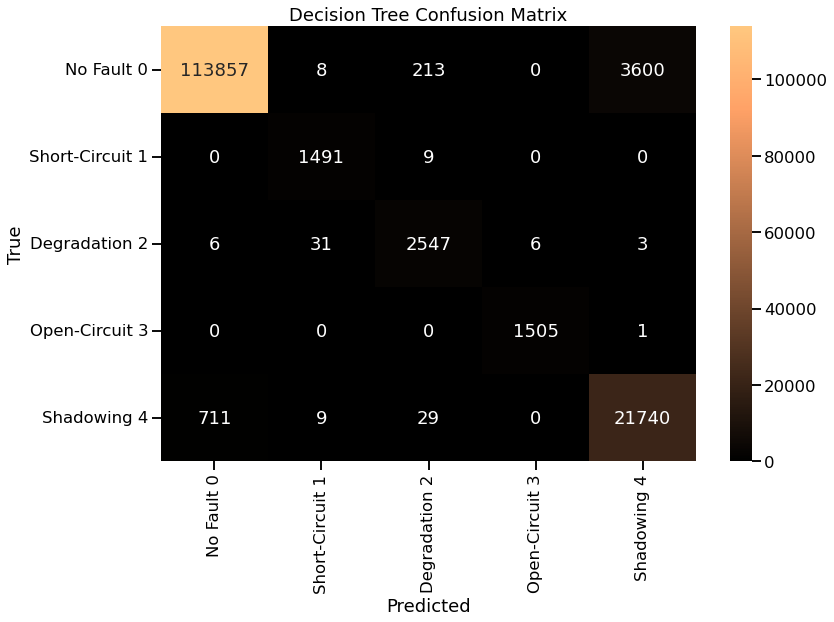

In [56]:
print(classification_report(y_test, preds))

sns.set_context('talk')
cm = confusion_matrix(y_test, preds)
plt.figure(figsize = (12,8)) 
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='copper',
                xticklabels=['No Fault 0', 'Short-Circuit 1', 'Degradation 2','Open-Circuit 3','Shadowing 4'], 
                 yticklabels=['No Fault 0', 'Short-Circuit 1', 'Degradation 2','Open-Circuit 3','Shadowing 4'])
ax.set(title="Decision Tree Confusion Matrix");
ax.set_xlabel('Predicted');
ax.set_ylabel('True');

In [57]:
#Storing evaluation metrics (average values)
dt_results = list()
for key in keys:
       dt_results.append(tree.get(key))
dt_results 

[0.9682642042726013,
 0.9710508060959091,
 0.9682642042726013,
 0.9689886675918266]

In [58]:
# storing evaluation metrics (per class)
dt_rpf = []
for element in elements:
       dt_rpf.append(tree.get(element))
dt_rpf  

[array([0.99374204, 0.96881092, 0.91029307, 0.99602912, 0.85779672]),
 array([0.96753004, 0.994     , 0.98225993, 0.99933599, 0.96669483]),
 array([0.98046088, 0.98124383, 0.94490818, 0.99767981, 0.90899588])]

In [59]:
pickle.dump(search_dt, open('search_dt.p','wb')) # write it as bytes
pickle.dump(dt_model, open('dt_model.p','wb')) # write it as bytes

`C - Random Forest`

In [60]:
# GridSearch using RandomForest is computationally expensive, to save time, will be skipped.

# # Identifying the param_grid to loop through it using GridSearchCV
# param_grid = {'n_estimators':[50,100,200],
#               'criterion':['gini', 'entropy'],
#               'max_features':[2,4,6]}
# model = RandomForestClassifier(random_state = rs, bootstrap = True, class_weight = class_weight)
# search_rf = GridSearchCV(estimator=model,
#                       param_grid=param_grid,
#                       scoring='accuracy',
#                       cv=kf,
#                       n_jobs = -1) # Initiate search object
# search_rf.fit(X_train_s, y_train)
# search_rf.best_score_
# search_rf.best_params_

In [61]:
rf_model = RandomForestClassifier(random_state = rs,
                                  bootstrap = True,
                                  class_weight= class_weight,
                                  criterion = 'gini',
                                  max_depth = 4,
                                  n_estimators = 200)
rf_model.fit(X_train_s,y_train)

RandomForestClassifier(class_weight={0: 0.05, 1: 0.3, 2: 0.2, 3: 0.3, 4: 0.15},
                       max_depth=4, n_estimators=200, random_state=123)

In [62]:
preds = rf_model.predict(X_test_s)
randomforest = evaluate_metrics(y_test,preds)
randomforest

{'accuracy': 0.9490004527804838,
 'precision': array([0.98890938, 0.99375434, 0.98519128, 0.99274885, 0.77783821]),
 'Weighted precision': 0.9563683817182562,
 'recall': array([0.9479002 , 0.95466667, 0.92364057, 1.        , 0.95388857]),
 'Weighted recall': 0.9490004527804838,
 'f1score': array([0.96797063, 0.97381843, 0.95342357, 0.99636123, 0.8569146 ]),
 'Weighted f1score': 0.9509314632166822}

              precision    recall  f1-score   support

           0       0.99      0.95      0.97    117678
           1       0.99      0.95      0.97      1500
           2       0.99      0.92      0.95      2593
           3       0.99      1.00      1.00      1506
           4       0.78      0.95      0.86     22489

    accuracy                           0.95    145766
   macro avg       0.95      0.96      0.95    145766
weighted avg       0.96      0.95      0.95    145766



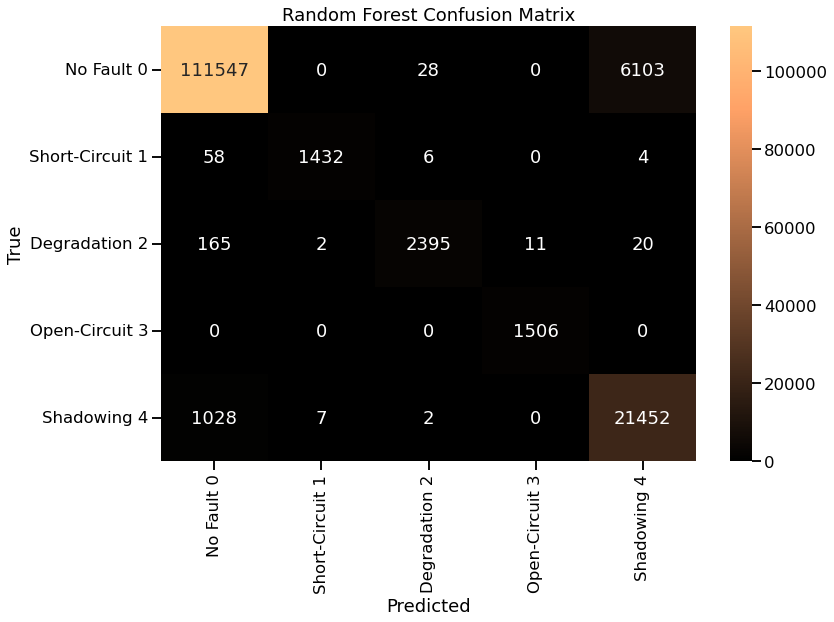

In [63]:
print(classification_report(y_test, preds))

sns.set_context('talk')
cm = confusion_matrix(y_test, preds)
plt.figure(figsize = (12,8)) 
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='copper',
                xticklabels=['No Fault 0', 'Short-Circuit 1', 'Degradation 2','Open-Circuit 3','Shadowing 4'], 
                 yticklabels=['No Fault 0', 'Short-Circuit 1', 'Degradation 2','Open-Circuit 3','Shadowing 4'])
ax.set(title="Random Forest Confusion Matrix");
ax.set_xlabel('Predicted');
ax.set_ylabel('True');

In [64]:
#Storing evaluation metrics (average values)
rf_results = list()
for key in keys:
       rf_results.append(randomforest.get(key))
rf_results 

[0.9490004527804838,
 0.9563683817182562,
 0.9490004527804838,
 0.9509314632166822]

In [65]:
# storing evaluation metrics (per class)
rf_rpf = []
for element in elements:
       rf_rpf.append(randomforest.get(element))
rf_rpf  

[array([0.98890938, 0.99375434, 0.98519128, 0.99274885, 0.77783821]),
 array([0.9479002 , 0.95466667, 0.92364057, 1.        , 0.95388857]),
 array([0.96797063, 0.97381843, 0.95342357, 0.99636123, 0.8569146 ])]

In [66]:
# pickle.dump(search_rf, open('search_rf.p','wb')) # write it as bytes
pickle.dump(rf_model, open('rf_model.p','wb')) # write it as bytes

In [67]:
final_results= {
    'Metric': ['Accuracy',' Weighted Precision','Weighted Recall','Weighted F1score'],
    'Logistic Regression' :lr_results,
    'Decision Tree'       :dt_results,
    'Random Forest'      :rf_results}
final_results = pd.DataFrame(final_results).set_index('Metric')
display(final_results)

,Logistic Regression,Decision Tree,Random Forest
Metric,,,
Accuracy,0.928221,0.968264,0.949000
Weighted Precision,0.933172,0.971051,0.956368
Weighted Recall,0.928221,0.968264,0.949000
Weighted F1score,0.930049,0.968989,0.950931


In [68]:
final_results_per_class = {
    'classes': [0,1,2,3,4],
    'LR Precision' :lr_rpf[0],
    'LR Recall' :lr_rpf[1],
    'LR F1score' :lr_rpf[2],
    'DT Precision':dt_rpf[0],
    'DT Recall':dt_rpf[1],
    'DT F1score':dt_rpf[2],
    'RF Precision':rf_rpf[0],
    'RF Recall':rf_rpf[1],
    'RF F1 score':rf_rpf[2]}
final_results_per_class = pd.DataFrame(final_results_per_class).set_index('classes')
final_results_per_class.T

classes,0,1,2,3,4
LR Precision,0.968607,0.972621,0.977138,0.990138,0.736238
LR Recall,0.943099,0.994667,0.956035,1.000000,0.837921
LR F1score,0.955683,0.983520,0.966472,0.995045,0.783795
DT Precision,0.993742,0.968811,0.910293,0.996029,0.857797
DT Recall,0.967530,0.994000,0.982260,0.999336,0.966695
DT F1score,0.980461,0.981244,0.944908,0.997680,0.908996
RF Precision,0.988909,0.993754,0.985191,0.992749,0.777838
RF Recall,0.947900,0.954667,0.923641,1.000000,0.953889
RF F1 score,0.967971,0.973818,0.953424,0.996361,0.856915


### 3 - Key Findings 
**A - The dataset is extremely skewed toward 'no fault'.**<br>
**B - Decision Tree and Random Forest models performed very well in the validation set.**<br>
**C - In terms of performance, Decision Tree is the best algorithm to use, then Random Forest, and lastly Logistic Regression.** 

### 4 - Possible Flaws & Suggestions for Future Work
**A - Reweighting was the best option to deal with the imbalanced data. However, there might be a room for rebalancing improvement.**<br>
**B - Logistic Regression model has a problem identifying class '4', because class '4' has a recall of 0.63 only.**<br>
**C - The frequency of measuring the PV panels attributes can be adjusted. Because within 16 days they measured 1,373,798 times, i.e., one measurement every second. Although it is adapting real-life scenarios, I recommend to reduce the capturing frequency to avoid plateauing the dataset with no fault status. if measurements are taken every two seconds, the dataset size will be reduced into half and same goal can be acheived.**<br>
**D - The major confusion is between class 0 and 4.**<br>

#### References
[1] Lazzaretti, A. E., Costa, C. H. D., Rodrigues, M. P., Yamada, G. D., Lexinoski, G., Moritz, G. L., Oroski, E., Goes, R. E. D., Linhares, R. R., Stadzisz, P. C., Omori, J. S., & Santos, R. B. D. (2020). A Monitoring System for Online Fault Detection and Classification in Photovoltaic Plants. Sensors, 20(17), 4688. https://doi.org/10.3390/s20174688
dataset link : https://github.com/clayton-h-costa/pv_fault_dataset